Use all available tokens as targets
 

# Install Libraries and imports

In [1]:
!pip install fastai -Uqq

     |████████████████████████████████| 189 kB 5.7 MB/s 
     |████████████████████████████████| 55 kB 3.0 MB/s 


In [2]:
from fastai.tabular.all import *
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import r2_score
from torch.utils.data import Dataset

# Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = Path('/content/drive/MyDrive/colab_notebooks/algovera/defi')

# Preparing the data

In [5]:
df = pd.read_csv(path/'compound.csv')
df["Date"] = pd.to_datetime(df["Timestamp"], unit='s', origin='unix')

tokens = df["Token"].unique()
tokens

array(['DAI', 'USDC', 'USDT', 'ETH'], dtype=object)

In [6]:
df = df.drop_duplicates(['Timestamp', 'Token'])
counts = pd.DataFrame(df['Timestamp'].value_counts()).reset_index()
counts.columns = ['Timestamp', 'Counts']
df = df.merge(counts, on='Timestamp')

In [7]:
df = df[df['Counts'] == 4].reset_index(drop=True).drop('Counts', axis=1)

In [8]:
df1 = pd.DataFrame()
for tok in tokens:
    df_tok = df[df['Token']==tok]
    df_tok = df_tok.drop(['Token', 'Date'], axis=1)

    col_names = []
    for col in df_tok.columns:
        if col == 'Timestamp':
            col_names.append(f'{col}')
        else:
            col_names.append(f'{tok}_{col}')
        
    df_tok.columns = col_names
    #df_tok = df_tok.set_index('Timestamp', drop=True)
    
    if df1.empty:
        df1 = df_tok
    else:
        df1 = pd.merge(df1, df_tok, on='Timestamp')

In [9]:
df1.sort_values('Timestamp', inplace=True)
df1["Date"] = pd.to_datetime(df1["Timestamp"], unit='s', origin='unix')

In [10]:
df1.head()

,Timestamp,DAI_Borrowing Rate,DAI_Deposit Rate,DAI_Borrow Volume,DAI_Supply Volume,USDC_Borrowing Rate,USDC_Deposit Rate,USDC_Borrow Volume,USDC_Supply Volume,USDT_Borrowing Rate,USDT_Deposit Rate,USDT_Borrow Volume,USDT_Supply Volume,ETH_Borrowing Rate,ETH_Deposit Rate,ETH_Borrow Volume,ETH_Supply Volume,Date
0,1609471800,0.073195,0.050982,1.069964e+09,6.196481e+10,0.087046,0.066993,7.285430e+08,4.063042e+10,0.099588,0.077548,6.430536e+07,3.696225e+09,0.022952,0.000489,30553.654354,5.663257e+07,2021-01-01 03:30:00
1,1609473600,0.073101,0.050912,1.069961e+09,6.197050e+10,0.087053,0.066998,7.285469e+08,4.063019e+10,0.094890,0.073569,6.407877e+07,3.700299e+09,0.022952,0.000489,30553.703955,5.663353e+07,2021-01-01 04:00:00
2,1609475400,0.073061,0.050882,1.069972e+09,6.197354e+10,0.087058,0.067003,7.285528e+08,4.063019e+10,0.085767,0.065933,6.399418e+07,3.729213e+09,0.022951,0.000489,30553.830472,5.664534e+07,2021-01-01 04:30:00
3,1609477200,0.073436,0.051161,1.070496e+09,6.197966e+10,0.086921,0.066889,7.285713e+08,4.063660e+10,0.072946,0.055500,6.317162e+07,3.730028e+09,0.022952,0.000489,30553.786270,5.663860e+07,2021-01-01 05:00:00
4,1609479000,0.067829,0.047015,1.070566e+09,6.234580e+10,0.086312,0.066383,7.285755e+08,4.066162e+10,0.057764,0.043239,6.256095e+07,3.752927e+09,0.022952,0.000489,30553.841412,5.663440e+07,2021-01-01 05:30:00


# Multi-timestep input

## fastai tabular model

In [11]:
def get_target(
    row:pd.Series, # Row to infer current timestamp 
    target_column:str, # Name of target column
    target_window:int, # # Number of timepoint into the future make prediction 
):
    'Prepares target based on target_window'
    try:
        target = df1[df1['Timestamp'] == row['Timestamp'] + 1800.0*target_window][target_column].values[0]
    except:
        target = np.NaN
    
    return target


def get_tabpandas_multi(
    df:pd.DataFrame, # Dataframe of the raw data 
    token:Str, # Token to predict `DAI`, `USDC`, `USDT`,  `ETH`
    target_window:int, # Number of timepoints in the future to predict 
    n_timepoint:int, # Number of previous timepoints to be used as features   
    inference:bool=False, # Flag True for inference
):
    'makes dataframe based on `n_timepoints` and `target_window`'
    df = df.reset_index(drop=True)
    feature_cols = ['DAI_Borrowing Rate', 'DAI_Deposit Rate', 'DAI_Borrow Volume', 'DAI_Supply Volume', 
                    'USDC_Borrowing Rate', 'USDC_Deposit Rate', 'USDC_Borrow Volume', 'USDC_Supply Volume', 
                    'USDT_Borrowing Rate', 'USDT_Deposit Rate', 'USDT_Borrow Volume', 'USDT_Supply Volume',
                    'ETH_Borrowing Rate', 'ETH_Deposit Rate', 'ETH_Borrow Volume', 'ETH_Supply Volume']

    #target_columns = ['DAI_Borrowing Rate', 'USDC_Borrowing Rate', 'USDT_Borrowing Rate', 'ETH_Borrowing Rate']
    target_column = [f'{token}_Borrowing Rate']
    target_column_name = [f'{token}_Target_{target_window}']
    
    cols_names = []
    for j in range(n_timepoint):
        for col in feature_cols:
            cols_names.append(f'{col}_t-{n_timepoint -j-1}')
    
    if not inference:
        cols_names += target_column_name
    #cols_names += [f'DAI_Target{target_window}', f'USDC_Target{target_window}', f'USDT_Target{target_window}', f'ETH_Target{target_window}']


    pairs = []
    for i, row in tqdm(df.iterrows()):
        if not inference:
            if i < (len(df)-target_window-n_timepoint-1):
                features = df.loc[i:i+n_timepoint-1, feature_cols].values
                features = [item for sublist in features for item in sublist]
                targ = list(df.loc[i+n_timepoint-1+target_window, target_column].values)
                features += targ
                pairs.append(features)
        if inference:
            if i < (len(df)):
                features = df.loc[i:i+n_timepoint-1, feature_cols].values
                features = [item for sublist in features for item in sublist]
                pairs.append(features)

    df = pd.DataFrame(pairs, columns=cols_names)
    df = df.dropna()
    df = df.reset_index(drop=True)
    
    #sanity check
    if not inference:
        assert 0 == sum(df[f'{token}_Borrowing Rate_t-0'].shift(-target_window).dropna() != df[f'{token}_Target_{target_window}'].iloc[:-target_window])

        #train_test_split
        
        df['Train'] = None
        train_index = int(len(df)*0.8)
        df.loc[:train_index, 'Train'] = True
        df.loc[train_index:, 'Train'] = False

        splits = (list(df[df['Train']==True].index), list(df[df['Train']==False].index))

        df = df.drop(['Train'], axis=1)

        cont_names = list(df.columns[:-1])

        procs = [Categorify, FillMissing, Normalize]
        y_block = RegressionBlock()

        to = TabularPandas(df, procs=procs, cont_names=cont_names, y_names=target_column_name, y_block=y_block, splits=splits)
        dls = to.dataloaders(bs=128)

        return df, to, dls
    
    if inference:
        return df

In [12]:
def get_learner_train(
    df_p:pd.DataFrame, # Prepared df
    token:str, # Token to predict `DAI`, `USDC`, `USDT`,  `ETH`
    n_timepoint:int, # Number of previous timepoints to be used as features   
    target_window:int, # Number of timepoints in the future to predict 
):
    'Gets learner and trains, best model is also saved'
    df, to, dls = get_tabpandas_multi(df_p, token, target_window, n_timepoint)
    sm = SaveModelCallback(fname=f'multitimepoint_fastaitabmodel_{token}_{n_timepoint}_{target_window}')

    learn = tabular_learner(dls, 
                        [200,100], 
                        metrics=rmse,
                        n_out=1,
                        cbs=sm)
    
    learn.fit_one_cycle(100, 0.03)

    return learn

def get_preds(
    learner, # fastai's learner 
):
    'gets prediciton and prints r2 score'
    preds, targs = learn.get_preds(dl=learn.dls.valid)
    targs, preds = targs.flatten().numpy(), preds.flatten().numpy()
    r2 = r2_score(preds, targs)
    print("fastai TabModel",":",r2_score(preds, targs))

    return targs, preds, r2

def plot_results(
    model_type:str, # Model type - fastai tabular model or LSTM model
    token:Str, # Token to predict `DAI`, `USDC`, `USDT`,  `ETH`
    n_timepoint:int, # Number of previous timepoints to be used as features   
    target_window:int, # Number of timepoints in the future to predict 
    targs, # Real y_values 
    preds, # Predicted y_values
    r2
):
    plt.figure(figsize=(10,10))
    plt.plot(range(len(targs)), targs)
    plt.plot(range(len(targs)), preds)
    plt.title(f'{model_type} {token} n_timepoint: {n_timepoint} target_window: {target_window} r2: {r2:.4f}')
    plt.legend(['Target', 'Prediction'])
    plt.savefig(f'{path}/results/{model_type} {token} n_timepoint {n_timepoint} target_window {target_window}')


In [ ]:
#for tok in ['USDC', 'USDT', 'ETH']:
#    for ntp in [1, 3, 10, 20]:
#        for tw in [3, 5, 10]:
#            learn = get_learner_train(tok, ntp, tw)
#            targs, preds, r2 = get_preds(learn)
#            plot_results(tok, ntp, tw, targs, preds, r2)

In [14]:
# learn = get_learner_train(df1, 'DAI', 3, 5)

## LSTM

In [20]:
class LSTMDataset(Dataset):
    def __init__(self, 
        df, # `to` from fastai tabular 
        n_timepoint:int, # Number of previous timepoints to be used as features   
        numfeatpertimepoint:int, # Number of features per timepoint 
    ):
        self.df = df.items.reset_index(drop=True)
        self.n_sequence = n_timepoint
        self.numfeatures = numfeatpertimepoint

    def __len__(self):
        return len(self.df)

    def __getitem__(self, 
        index
    ):
        row = self.df.loc[index,:]
        target = tensor(row.iloc[-1])
        features = [tensor(list(row[i*self.numfeatures:(i*self.numfeatures+self.numfeatures)].values)) for i in range(self.n_sequence)]
        features = torch.stack(features)
        return (features, target)

class LSTMTestDataset(Dataset):
    def __init__(self, 
        df, # `to` from fastai tabular 
        n_timepoint:int, # Number of previous timepoints to be used as features   
        numfeatpertimepoint:int, # Number of features per timepoint 
    ):
        self.df = df.items.reset_index(drop=True)
        self.n_sequence = n_timepoint
        self.numfeatures = numfeatpertimepoint

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.loc[index,:]
        features = [tensor(list(row[i*self.numfeatures:(i*self.numfeatures+self.numfeatures)].values)) for i in range(self.n_sequence)]
        features = torch.stack(features)
        return (features,)


class LSTMModel(nn.Module):
    def __init__(self, 
        input_size:int, # Number of features per timepoint
        hidden_size:int, # Hidden size to be used 
        num_layers:int=2, # Number of LSTM layers to use
        num_classes:int=1, # Output size
    ):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)


    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = out[:, -1, :]
        out = self.fc(out)

        return out

In [21]:
def get_lstm_learner_train(
    df_p:pd.DataFrame, # Prepared df
    token:str, # Token to predict `DAI`, `USDC`, `USDT`,  `ETH`
    n_timepoint:int, # Number of previous timepoints to be used as features   
    target_window:int, # Number of timepoints in the future to predict 
):
    
    df, to, dls_pre = get_tabpandas_multi(df_p, token, target_window, n_timepoint)
    train_dset = LSTMDataset(to.train, n_timepoint, 16)
    valid_dset = LSTMDataset(to.valid, n_timepoint, 16)
    dls = DataLoaders.from_dsets(train_dset, valid_dset, bs=128)

    sm = SaveModelCallback(fname=f'{token}_{n_timepoint}_{target_window}')

    model = LSTMModel(16, 128)
    learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=sm)
    
    learn.fit_one_cycle(10, 0.03)

    return learn, dls_pre

13766it [00:24, 573.13it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000345,0.000144,0.012017,00:04
1,0.000078,0.000004,0.002006,00:04
2,0.000032,0.000003,0.001663,00:04
3,0.000048,0.000019,0.004328,00:04
4,0.000036,0.000004,0.001944,00:04
5,0.000039,0.000029,0.005361,00:04
6,0.000039,0.000006,0.002379,00:04
7,0.000032,0.000004,0.002023,00:04
8,0.000031,0.000003,0.001780,00:04
9,0.000027,0.000003,0.001824,00:04


Better model found at epoch 0 with valid_loss value: 0.00014440416998695582.
Better model found at epoch 1 with valid_loss value: 4.0228796933661215e-06.
Better model found at epoch 2 with valid_loss value: 2.765753606581711e-06.
Better model found at epoch 14 with valid_loss value: 2.369399908275227e-06.
Better model found at epoch 18 with valid_loss value: 2.3231036720972043e-06.


fastai TabModel : 0.9003919912931999


13766it [00:20, 672.55it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000079,0.000017,0.004141,00:04
1,0.000046,0.000005,0.002313,00:04
2,0.000045,0.000008,0.002874,00:04
3,0.000049,0.000006,0.002515,00:04
4,0.000051,0.000014,0.003730,00:04
5,0.000045,0.000018,0.004292,00:04
6,0.000056,0.000012,0.003402,00:04
7,0.000040,0.000007,0.002697,00:04
8,0.000041,0.000013,0.003643,00:04
9,0.000046,0.000004,0.002083,00:04


Better model found at epoch 0 with valid_loss value: 1.7146692698588595e-05.
Better model found at epoch 1 with valid_loss value: 5.3513399507210124e-06.
Better model found at epoch 9 with valid_loss value: 4.3407776502135675e-06.
Better model found at epoch 13 with valid_loss value: 3.818298864644021e-06.


fastai TabModel : 0.808872780103902


13766it [00:20, 667.25it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000108,0.000014,0.003711,00:04
1,0.000066,0.000019,0.004356,00:04
2,0.000071,0.000010,0.003177,00:04
3,0.000067,0.000009,0.002938,00:04
4,0.000074,0.000010,0.003146,00:04
5,0.000074,0.000018,0.004263,00:04
6,0.000070,0.000020,0.004418,00:04
7,0.000062,0.000013,0.003538,00:04
8,0.000061,0.000012,0.003531,00:04
9,0.000062,0.000018,0.004234,00:04


Better model found at epoch 0 with valid_loss value: 1.3772976672044024e-05.
Better model found at epoch 2 with valid_loss value: 1.0096498954226263e-05.
Better model found at epoch 3 with valid_loss value: 8.634729965706356e-06.
Better model found at epoch 11 with valid_loss value: 7.553438535978785e-06.


fastai TabModel : 0.6707502698722492


13766it [00:21, 651.50it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000100,0.000015,0.003912,00:07
1,0.000041,0.000013,0.003640,00:07
2,0.000039,0.000020,0.004509,00:07
3,0.000035,0.000005,0.002159,00:07
4,0.009454,0.000224,0.014982,00:07
5,0.001793,0.000158,0.012583,00:07
6,0.000381,0.000205,0.014330,00:07
7,0.000117,0.000179,0.013370,00:07
8,0.000053,0.000163,0.012756,00:07
9,0.000042,0.000155,0.012465,00:07


Better model found at epoch 0 with valid_loss value: 1.5306966815842316e-05.
Better model found at epoch 1 with valid_loss value: 1.3248686627775896e-05.
Better model found at epoch 3 with valid_loss value: 4.662703759095166e-06.


fastai TabModel : 0.7052541709293029


13766it [00:21, 655.48it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000204,0.000086,0.009248,00:07
1,0.000066,0.000005,0.002165,00:07
2,0.000048,0.000006,0.002487,00:07
3,0.000068,0.000040,0.006354,00:07
4,0.006336,0.000864,0.029396,00:07
5,0.001207,0.000523,0.022859,00:07
6,0.000255,0.000442,0.021028,00:07
7,0.000085,0.000386,0.019640,00:07
8,0.000051,0.000359,0.018957,00:07
9,0.000050,0.000313,0.017690,00:07


Better model found at epoch 0 with valid_loss value: 8.553243242204189e-05.
Better model found at epoch 1 with valid_loss value: 4.687640739575727e-06.


fastai TabModel : 0.755910522078139


13766it [00:20, 669.81it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000115,0.000022,0.004678,00:07
1,0.000072,0.000016,0.004055,00:07
2,0.000070,0.000028,0.005260,00:07
3,0.000073,0.000033,0.005774,00:07
4,0.041879,0.000478,0.021864,00:07
5,0.007655,0.000183,0.013535,00:07
6,0.001452,0.000155,0.012432,00:07
7,0.000321,0.000118,0.010859,00:07
8,0.000109,0.000075,0.008660,00:07
9,0.000074,0.000056,0.007463,00:07


Better model found at epoch 0 with valid_loss value: 2.187968129874207e-05.
Better model found at epoch 1 with valid_loss value: 1.6445583241875283e-05.


fastai TabModel : 0.34728056505544214


13766it [00:21, 650.18it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000202,0.000011,0.003384,00:15
1,0.000052,0.000007,0.002706,00:15
2,0.000041,0.000003,0.001782,00:15
3,0.000038,0.000007,0.002702,00:15
4,0.000039,0.000010,0.003108,00:15
5,0.084896,0.000692,0.026305,00:15
6,0.015720,0.000282,0.016795,00:15
7,0.002977,0.000197,0.014019,00:15
8,0.000655,0.000151,0.012305,00:15
9,0.000302,0.000126,0.011229,00:15


Better model found at epoch 0 with valid_loss value: 1.1452018952695653e-05.
Better model found at epoch 1 with valid_loss value: 7.321256362047279e-06.
Better model found at epoch 2 with valid_loss value: 3.174128096361528e-06.


fastai TabModel : 0.8549055954665958


13766it [00:21, 645.69it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000071,0.000010,0.003197,00:15
1,0.000055,0.000012,0.003524,00:15
2,0.000047,0.000008,0.002889,00:15
3,0.047276,0.005351,0.073151,00:15
4,0.008695,0.000343,0.018523,00:15
5,0.001615,0.000299,0.017282,00:15
6,0.000388,0.000321,0.017923,00:15
7,0.000159,0.000233,0.015258,00:15
8,0.000270,0.000066,0.008113,00:15
9,0.000100,0.000104,0.010213,00:15


Better model found at epoch 0 with valid_loss value: 1.0222280252492055e-05.
Better model found at epoch 2 with valid_loss value: 8.343755325768143e-06.


fastai TabModel : 0.6872415299040007


13766it [00:21, 648.88it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000331,0.000046,0.006759,00:15
1,0.000099,0.000008,0.002892,00:15
2,0.000078,0.000025,0.005011,00:15
3,0.000079,0.000012,0.003532,00:15
4,0.000083,0.000024,0.004927,00:15
5,0.000082,0.000010,0.003166,00:15
6,0.000069,0.000012,0.003475,00:15
7,0.014023,0.000629,0.025073,00:15
8,0.002774,0.000144,0.012006,00:15
9,0.000577,0.000128,0.011299,00:15


Better model found at epoch 0 with valid_loss value: 4.567804353428073e-05.
Better model found at epoch 1 with valid_loss value: 8.365945177501999e-06.


fastai TabModel : 0.610165698855998


13766it [00:22, 608.25it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000400,0.000009,0.002955,00:27
1,0.000085,0.000006,0.002513,00:27
2,0.000043,0.000006,0.002436,00:27
3,0.000075,0.000036,0.006001,00:27
4,0.000041,0.000010,0.003152,00:27
5,0.000044,0.000008,0.002913,00:26
6,0.000034,0.000014,0.003709,00:26
7,0.000030,0.000011,0.003327,00:26
8,0.000027,0.000009,0.003080,00:26
9,0.000031,0.000006,0.002479,00:26


Better model found at epoch 0 with valid_loss value: 8.731733942113351e-06.
Better model found at epoch 1 with valid_loss value: 6.317234692687634e-06.
Better model found at epoch 2 with valid_loss value: 5.9337567108741496e-06.
Better model found at epoch 10 with valid_loss value: 3.1350177778222132e-06.
Better model found at epoch 12 with valid_loss value: 3.0390847314265557e-06.
Better model found at epoch 14 with valid_loss value: 2.4713297079870244e-06.
Better model found at epoch 17 with valid_loss value: 2.3230356873682467e-06.


fastai TabModel : 0.8954485607609003


13766it [00:21, 629.31it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000127,0.000012,0.003535,00:27
1,0.000056,0.000005,0.002286,00:27
2,0.000054,0.000007,0.002694,00:27
3,0.000080,0.000257,0.016042,00:26
4,0.018448,0.000300,0.017322,00:28
5,0.003554,0.000123,0.011091,00:28
6,0.001220,0.002239,0.047315,00:28
7,0.000696,0.000884,0.029740,00:28
8,0.000611,0.001236,0.035151,00:27
9,0.000391,0.000487,0.022071,00:27


Better model found at epoch 0 with valid_loss value: 1.2499656804720871e-05.
Better model found at epoch 1 with valid_loss value: 5.22545587955392e-06.


fastai TabModel : 0.7243301263798632


13766it [00:22, 622.02it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000185,0.000042,0.006501,00:27
1,0.000086,0.000020,0.004450,00:27
2,0.000078,0.000013,0.003652,00:27
3,0.000088,0.000012,0.003484,00:27
4,0.000087,0.000010,0.003234,00:27
5,0.000077,0.000022,0.004725,00:26
6,0.000074,0.000023,0.004762,00:26
7,0.000070,0.000008,0.002835,00:27
8,0.000060,0.000023,0.004797,00:27
9,0.000059,0.000018,0.004293,00:27


Better model found at epoch 0 with valid_loss value: 4.2263505747541785e-05.
Better model found at epoch 1 with valid_loss value: 1.980633351195138e-05.
Better model found at epoch 2 with valid_loss value: 1.3340032637643162e-05.
Better model found at epoch 3 with valid_loss value: 1.2137987141613849e-05.
Better model found at epoch 4 with valid_loss value: 1.0460273188073188e-05.
Better model found at epoch 7 with valid_loss value: 8.039951353566721e-06.


fastai TabModel : 0.560859518550576


13766it [00:22, 605.25it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.001064,0.000032,0.005690,00:05
1,0.000198,0.000022,0.004713,00:04
2,0.000070,0.000030,0.005451,00:04
3,0.000063,0.000030,0.005465,00:04
4,0.000088,0.000030,0.005447,00:04
5,0.000055,0.000022,0.004661,00:04
6,0.000052,0.000026,0.005124,00:04
7,0.000043,0.000026,0.005112,00:04
8,0.000045,0.000028,0.005305,00:04
9,0.000043,0.000024,0.004916,00:04


Better model found at epoch 0 with valid_loss value: 3.2378611649619415e-05.
Better model found at epoch 1 with valid_loss value: 2.22077542275656e-05.
Better model found at epoch 5 with valid_loss value: 2.172293170588091e-05.
Better model found at epoch 13 with valid_loss value: 2.1162242774153128e-05.
Better model found at epoch 15 with valid_loss value: 2.113694245053921e-05.
Better model found at epoch 17 with valid_loss value: 2.0537805539788678e-05.
Better model found at epoch 18 with valid_loss value: 2.050804869213607e-05.


fastai TabModel : 0.9499531484287027


13766it [00:21, 642.95it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000997,0.000142,0.011906,00:04
1,0.000207,0.000048,0.006907,00:04
2,0.000090,0.000036,0.005994,00:04
3,0.000069,0.000040,0.006355,00:04
4,0.000088,0.000036,0.006041,00:04
5,0.000073,0.000038,0.006125,00:04
6,0.000066,0.000046,0.006778,00:04
7,0.000064,0.000046,0.006807,00:04
8,0.000063,0.000040,0.006295,00:04
9,0.000064,0.000038,0.006184,00:05


Better model found at epoch 0 with valid_loss value: 0.00014174538955558091.
Better model found at epoch 1 with valid_loss value: 4.7707675548736006e-05.
Better model found at epoch 2 with valid_loss value: 3.592687789932825e-05.
Better model found at epoch 12 with valid_loss value: 3.4755950764520094e-05.
Better model found at epoch 14 with valid_loss value: 3.423309317440726e-05.


fastai TabModel : 0.9160694832744296


13766it [00:20, 664.15it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000364,0.000062,0.007898,00:04
1,0.000130,0.000067,0.008188,00:04
2,0.000106,0.000084,0.009160,00:04
3,0.000110,0.000074,0.008603,00:04
4,0.000105,0.000065,0.008051,00:04
5,0.000114,0.000077,0.008803,00:04
6,0.000112,0.000064,0.008025,00:04
7,0.000107,0.000066,0.008151,00:04
8,0.000101,0.000063,0.007969,00:04
9,0.000102,0.000066,0.008110,00:04


Better model found at epoch 0 with valid_loss value: 6.237337947823107e-05.


fastai TabModel : 0.8079619390984674


13766it [00:21, 646.81it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000426,0.000036,0.005978,00:07
1,0.000101,0.000033,0.005779,00:07
2,0.000064,0.000025,0.005020,00:07
3,0.000107,0.000038,0.006200,00:07
4,0.000060,0.000023,0.004835,00:07
5,0.000051,0.000024,0.004945,00:07
6,0.000040,0.000028,0.005276,00:07
7,0.000046,0.000023,0.004797,00:07
8,0.000045,0.000102,0.010089,00:07
9,0.000039,0.000022,0.004654,00:07


Better model found at epoch 0 with valid_loss value: 3.5732751712203026e-05.
Better model found at epoch 1 with valid_loss value: 3.3400134270777926e-05.
Better model found at epoch 2 with valid_loss value: 2.520399539207574e-05.
Better model found at epoch 4 with valid_loss value: 2.337494515813887e-05.
Better model found at epoch 7 with valid_loss value: 2.3010032236925326e-05.
Better model found at epoch 9 with valid_loss value: 2.165740261261817e-05.
Better model found at epoch 10 with valid_loss value: 2.082145874737762e-05.
Better model found at epoch 16 with valid_loss value: 2.0651667000493035e-05.
Better model found at epoch 17 with valid_loss value: 2.032274096563924e-05.
Better model found at epoch 19 with valid_loss value: 2.010866955970414e-05.


fastai TabModel : 0.950069962950236


13766it [00:21, 638.33it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000134,0.000045,0.006712,00:07
1,0.000079,0.000045,0.006716,00:07
2,0.000073,0.000080,0.008948,00:07
3,0.000084,0.000060,0.007722,00:07
4,0.001811,0.744130,0.862630,00:07
5,0.012388,0.000914,0.030235,00:07
6,0.002307,0.000696,0.026382,00:07
7,0.000485,0.000507,0.022518,00:07
8,0.000148,0.000458,0.021411,00:07
9,0.000086,0.000420,0.020489,00:07


Better model found at epoch 0 with valid_loss value: 4.5054905058350414e-05.


fastai TabModel : 0.8531168279012986


13766it [00:21, 650.62it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000165,0.000066,0.008120,00:07
1,0.000113,0.000076,0.008746,00:07
2,0.000116,0.000068,0.008262,00:07
3,0.000118,0.000121,0.011010,00:07
4,0.031498,0.002417,0.049165,00:07
5,0.005903,0.000369,0.019197,00:07
6,0.001411,0.000583,0.024143,00:07
7,0.000567,0.000785,0.028016,00:07
8,0.001535,0.000529,0.023002,00:07
9,0.000614,0.000125,0.011188,00:07


Better model found at epoch 0 with valid_loss value: 6.593455327674747e-05.


fastai TabModel : 0.8056052198114405


13766it [00:21, 640.53it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000244,0.000057,0.007517,00:15
1,0.000078,0.000029,0.005363,00:15
2,0.000052,0.000030,0.005496,00:15
3,0.000047,0.000024,0.004866,00:15
4,0.135488,0.001009,0.031766,00:15
5,0.024570,0.000450,0.021221,00:15
6,0.004515,0.000271,0.016457,00:15
7,0.000899,0.000252,0.015868,00:15
8,0.000241,0.000271,0.016459,00:15
9,0.000133,0.000200,0.014131,00:15


Better model found at epoch 0 with valid_loss value: 5.650836828863248e-05.
Better model found at epoch 1 with valid_loss value: 2.876538383134175e-05.
Better model found at epoch 3 with valid_loss value: 2.3681583115831017e-05.


fastai TabModel : 0.9441430686823936


13766it [00:22, 609.12it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000227,0.000038,0.006168,00:16
1,0.000087,0.000046,0.006750,00:15
2,0.000069,0.000048,0.006896,00:15
3,0.000089,0.000057,0.007571,00:15
4,0.000074,0.000033,0.005765,00:15
5,0.055911,0.001741,0.041730,00:16
6,0.010365,0.000889,0.029815,00:15
7,0.002101,0.000766,0.027670,00:15
8,0.000539,0.000938,0.030623,00:16
9,0.000272,0.000360,0.018983,00:15


Better model found at epoch 0 with valid_loss value: 3.8039263017708436e-05.
Better model found at epoch 4 with valid_loss value: 3.3236115996260196e-05.


fastai TabModel : 0.9190617495224646


13766it [00:21, 646.56it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000163,0.000114,0.010680,00:15
1,0.000118,0.000073,0.008536,00:15
2,0.000129,0.000093,0.009662,00:15
3,0.000144,0.000088,0.009386,00:15
4,0.000110,0.000076,0.008741,00:15
5,0.000110,0.000107,0.010338,00:15
6,0.036211,0.000456,0.021366,00:16
7,0.006684,0.000325,0.018034,00:16
8,0.001358,0.000249,0.015777,00:16
9,0.000387,0.000246,0.015677,00:16


Better model found at epoch 0 with valid_loss value: 0.00011406019621063024.
Better model found at epoch 1 with valid_loss value: 7.286484469659626e-05.


fastai TabModel : 0.7542470458276636


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
13766it [00:22, 609.32it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000403,0.000030,0.005522,00:27
1,0.000099,0.000025,0.004965,00:27
2,0.000059,0.000035,0.005956,00:27
3,0.000063,0.000035,0.005920,00:27
4,0.000060,0.000029,0.005403,00:27
5,0.000054,0.000032,0.005686,00:27
6,0.000048,0.000024,0.004863,00:27
7,0.000043,0.000021,0.004534,00:27
8,0.000045,0.000022,0.004735,00:27
9,0.000043,0.000023,0.004785,00:27


Better model found at epoch 0 with valid_loss value: 3.048878352274187e-05.
Better model found at epoch 1 with valid_loss value: 2.4648374164826237e-05.
Better model found at epoch 6 with valid_loss value: 2.3644934117328376e-05.
Better model found at epoch 7 with valid_loss value: 2.0559145923471078e-05.
Better model found at epoch 11 with valid_loss value: 2.01631282834569e-05.


fastai TabModel : 0.9491816087624828


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
13766it [00:21, 626.44it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000090,0.000051,0.007134,00:27
1,0.000084,0.000147,0.012128,00:27
2,0.000077,0.000038,0.006196,00:27
3,0.000075,0.000037,0.006048,00:27
4,0.024486,0.002998,0.054753,00:27
5,0.004679,0.002304,0.047999,00:27
6,0.001643,0.003937,0.062749,00:27
7,0.000984,0.002470,0.049694,00:27
8,0.000851,0.002294,0.047894,00:27
9,0.000401,0.002331,0.048275,00:27


Better model found at epoch 0 with valid_loss value: 5.089759360998869e-05.
Better model found at epoch 2 with valid_loss value: 3.8392867281800136e-05.
Better model found at epoch 3 with valid_loss value: 3.658400964923203e-05.


fastai TabModel : 0.901810327991099


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
13766it [00:23, 597.62it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000162,0.000064,0.007992,00:28
1,0.000120,0.000109,0.010433,00:28
2,0.000114,0.000087,0.009304,00:28
3,0.000114,0.000082,0.009039,00:27
4,0.004194,0.000233,0.015248,00:28
5,0.000847,0.000142,0.011898,00:28
6,0.000261,0.000186,0.013647,00:28
7,0.000123,0.000145,0.012041,00:28
8,0.000092,0.000118,0.010840,00:28
9,0.000097,0.000139,0.011804,00:28


Better model found at epoch 0 with valid_loss value: 6.387678149621934e-05.


fastai TabModel : 0.8403105662386586


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
13766it [00:21, 650.65it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.001689,0.000475,0.021796,00:05
1,0.000432,0.000242,0.015566,00:05
2,0.000251,0.000251,0.015837,00:04
3,0.000254,0.000246,0.015695,00:05
4,0.000246,0.000239,0.015444,00:05
5,0.000264,0.000246,0.015691,00:05
6,0.000234,0.000253,0.015898,00:05
7,0.000225,0.000280,0.016736,00:05
8,0.000214,0.000279,0.016696,00:05
9,0.000212,0.000278,0.016666,00:05


Better model found at epoch 0 with valid_loss value: 0.000475073407869786.
Better model found at epoch 1 with valid_loss value: 0.00024229766859207302.
Better model found at epoch 4 with valid_loss value: 0.00023853027960285544.
Better model found at epoch 10 with valid_loss value: 0.0002376740740146488.
Better model found at epoch 12 with valid_loss value: 0.00023140689881984144.
Better model found at epoch 13 with valid_loss value: 0.00022535485913977027.


fastai TabModel : 0.8156559278355788


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
13766it [00:21, 639.34it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.001169,0.000463,0.021510,00:05
1,0.000465,0.000387,0.019666,00:05
2,0.000367,0.000388,0.019703,00:05
3,0.000429,0.000414,0.020351,00:05
4,0.000370,0.000494,0.022230,00:05
5,0.000370,0.000505,0.022481,00:05
6,0.000346,0.000430,0.020747,00:04
7,0.000316,0.000439,0.020960,00:05
8,0.000313,0.000417,0.020428,00:04
9,0.000315,0.000429,0.020711,00:04


Better model found at epoch 0 with valid_loss value: 0.0004626856534741819.
Better model found at epoch 1 with valid_loss value: 0.00038673539529554546.


fastai TabModel : 0.6417769025340618


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
13766it [00:21, 651.48it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.001793,0.000917,0.030290,00:05
1,0.000694,0.000654,0.025564,00:05
2,0.000562,0.000665,0.025783,00:05
3,0.000551,0.000708,0.026610,00:04
4,0.000532,0.000730,0.027012,00:05
5,0.000512,0.000662,0.025729,00:04
6,0.000473,0.000762,0.027610,00:05
7,0.000469,0.000703,0.026522,00:05
8,0.000454,0.000901,0.030023,00:05
9,0.000448,0.000711,0.026661,00:04


Better model found at epoch 0 with valid_loss value: 0.0009174973238259554.
Better model found at epoch 1 with valid_loss value: 0.0006535115535371006.


fastai TabModel : -0.04388207038788239


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
13766it [00:21, 639.69it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000310,0.000326,0.018047,00:07
1,0.000261,0.000267,0.016341,00:07
2,0.000222,0.000246,0.015692,00:07
3,0.010037,0.001113,0.033365,00:07
4,0.002108,0.000359,0.018948,00:07
5,0.000578,0.000288,0.016978,00:07
6,0.000267,0.000310,0.017613,00:07
7,0.000221,0.000270,0.016441,00:07
8,0.000215,0.000307,0.017525,00:07
9,0.000213,0.000421,0.020525,00:07


Better model found at epoch 0 with valid_loss value: 0.0003256897034589201.
Better model found at epoch 1 with valid_loss value: 0.0002670175163075328.
Better model found at epoch 2 with valid_loss value: 0.00024622623459436.


fastai TabModel : 0.7723697603063873


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
13766it [00:21, 651.50it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000606,0.000428,0.020680,00:07
1,0.000392,0.000408,0.020190,00:07
2,0.000387,0.000428,0.020691,00:07
3,0.000379,0.000373,0.019319,00:07
4,0.000339,0.000373,0.019306,00:07
5,0.000339,0.000401,0.020030,00:07
6,0.000337,0.000404,0.020102,00:07
7,0.000316,0.000369,0.019198,00:07
8,0.000301,0.000386,0.019637,00:07
9,0.000337,0.000415,0.020368,00:07


Better model found at epoch 0 with valid_loss value: 0.00042766190017573535.
Better model found at epoch 1 with valid_loss value: 0.0004076385812368244.
Better model found at epoch 3 with valid_loss value: 0.00037323939613997936.
Better model found at epoch 4 with valid_loss value: 0.0003727145667653531.
Better model found at epoch 7 with valid_loss value: 0.0003685658739414066.


fastai TabModel : 0.6582857578694115


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
13766it [00:21, 649.70it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000956,0.000652,0.025540,00:07
1,0.000579,0.000666,0.025812,00:07
2,0.000548,0.000649,0.025470,00:07
3,0.000500,0.000648,0.025449,00:07
4,0.000534,0.000756,0.027495,00:07
5,0.000516,0.000696,0.026372,00:07
6,0.000480,0.000706,0.026566,00:07
7,0.000465,0.000783,0.027989,00:07
8,0.000477,0.000832,0.028851,00:07
9,0.000450,0.000779,0.027914,00:07


Better model found at epoch 0 with valid_loss value: 0.0006522830808535218.
Better model found at epoch 2 with valid_loss value: 0.0006487003993242979.
Better model found at epoch 3 with valid_loss value: 0.0006476618000306189.


fastai TabModel : -0.016513351125200915


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
13766it [00:21, 628.61it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000611,0.000273,0.016515,00:16
1,0.000299,0.000276,0.016622,00:16
2,0.000239,0.000245,0.015668,00:16
3,0.000248,0.000282,0.016782,00:16
4,0.000245,0.000235,0.015343,00:16
5,0.008642,0.000766,0.027676,00:16
6,0.001788,0.000375,0.019358,00:16
7,0.000492,0.000307,0.017513,00:16
8,0.000245,0.000276,0.016614,00:16
9,0.000207,0.000295,0.017162,00:16


Better model found at epoch 0 with valid_loss value: 0.00027272928855381906.
Better model found at epoch 2 with valid_loss value: 0.0002454727073200047.
Better model found at epoch 4 with valid_loss value: 0.00023542190319858491.


fastai TabModel : 0.8326694312200204


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
13766it [00:21, 627.15it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000425,0.000433,0.020810,00:16
1,0.000366,0.000452,0.021256,00:15
2,0.000327,0.000372,0.019278,00:15
3,0.000337,0.000381,0.019516,00:16
4,0.018353,0.001087,0.032966,00:15
5,0.003633,0.000782,0.027967,00:16
6,0.000963,0.000754,0.027467,00:16
7,0.000450,0.000669,0.025858,00:15
8,0.000367,0.000555,0.023554,00:15
9,0.000376,0.000567,0.023817,00:15


Better model found at epoch 0 with valid_loss value: 0.00043306819861754775.
Better model found at epoch 2 with valid_loss value: 0.00037163891829550266.


fastai TabModel : 0.5933600474644991


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
13766it [00:24, 568.71it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000616,0.000677,0.026018,00:16
1,0.000521,0.000664,0.025775,00:16
2,0.000508,0.000780,0.027927,00:16
3,0.000518,0.000680,0.026072,00:15
4,0.000535,0.000652,0.025544,00:16
5,0.000491,0.000665,0.025794,00:16
6,0.000459,0.000663,0.025758,00:16
7,0.000449,0.000871,0.029513,00:16
8,0.000457,0.000832,0.028845,00:16
9,0.000426,0.000852,0.029181,00:16


Better model found at epoch 0 with valid_loss value: 0.0006769256433472037.
Better model found at epoch 1 with valid_loss value: 0.0006643672240898013.
Better model found at epoch 4 with valid_loss value: 0.0006524736527353525.


fastai TabModel : 0.17579268657855618


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
13766it [00:22, 617.63it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000335,0.000269,0.016393,00:27
1,0.000240,0.000280,0.016738,00:27
2,0.000226,0.000236,0.015346,00:28
3,0.000243,0.000263,0.016223,00:27
4,0.000256,0.000221,0.014856,00:27
5,0.000236,0.000243,0.015592,00:27
6,0.000224,0.000235,0.015340,00:27
7,0.000226,0.000229,0.015133,00:27
8,0.000199,0.000230,0.015167,00:28
9,0.000246,0.000284,0.016851,00:27


Better model found at epoch 0 with valid_loss value: 0.00026871453155763447.
Better model found at epoch 2 with valid_loss value: 0.00023550579498987645.
Better model found at epoch 4 with valid_loss value: 0.0002206893259426579.
Better model found at epoch 13 with valid_loss value: 0.00021352467592805624.


fastai TabModel : 0.8199843673030767


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
13766it [00:22, 604.64it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000534,0.000435,0.020857,00:28
1,0.000359,0.000398,0.019942,00:27
2,0.000353,0.000406,0.020153,00:28
3,0.000443,0.000400,0.020012,00:29
4,0.000360,0.000442,0.021016,00:28
5,0.000331,0.000438,0.020918,00:27
6,0.000337,0.000407,0.020162,00:27
7,0.000304,0.000437,0.020904,00:28
8,0.000346,0.000389,0.019731,00:27
9,0.000309,0.000452,0.021260,00:27


Better model found at epoch 0 with valid_loss value: 0.0004350300005171448.
Better model found at epoch 1 with valid_loss value: 0.0003976871375925839.
Better model found at epoch 8 with valid_loss value: 0.0003893273533321917.
Better model found at epoch 10 with valid_loss value: 0.0003719323722179979.
Better model found at epoch 12 with valid_loss value: 0.00036496983375400305.


fastai TabModel : 0.6616915855843832


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
13766it [00:22, 624.53it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000964,0.000683,0.026132,00:27
1,0.000590,0.000668,0.025848,00:27
2,0.000589,0.000906,0.030100,00:27
3,0.000520,0.000802,0.028323,00:27
4,0.000501,0.000661,0.025705,00:27
5,0.000466,0.000657,0.025640,00:27
6,0.000511,0.000713,0.026701,00:27
7,0.000455,0.000694,0.026339,00:27
8,0.000446,0.000715,0.026748,00:27
9,0.000435,0.000811,0.028476,00:27


Better model found at epoch 0 with valid_loss value: 0.0006828815676271915.
Better model found at epoch 1 with valid_loss value: 0.0006681386148557067.
Better model found at epoch 4 with valid_loss value: 0.0006607419927604496.
Better model found at epoch 5 with valid_loss value: 0.0006574305589310825.


fastai TabModel : 0.07983612084513403


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
13766it [00:21, 639.97it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000179,0.000002,0.001572,00:05
1,0.000028,0.000000,0.000381,00:05
2,0.000005,0.000000,0.000292,00:05
3,0.000014,0.000005,0.002320,00:05
4,0.000004,0.000000,0.000158,00:05
5,0.000003,0.000000,0.000475,00:05
6,0.000001,0.000000,0.000162,00:05
7,0.000001,0.000000,0.000342,00:05
8,0.000001,0.000000,0.000161,00:05
9,0.000001,0.000000,0.000236,00:05


Better model found at epoch 0 with valid_loss value: 2.4698003926459933e-06.
Better model found at epoch 1 with valid_loss value: 1.4494023048428062e-07.
Better model found at epoch 2 with valid_loss value: 8.498250281263608e-08.
Better model found at epoch 4 with valid_loss value: 2.5117996571566437e-08.
Better model found at epoch 12 with valid_loss value: 1.079738254361473e-08.
Better model found at epoch 16 with valid_loss value: 9.698140956970747e-09.
Better model found at epoch 19 with valid_loss value: 9.561787805978383e-09.


fastai TabModel : 0.9864735050237738


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
13766it [00:21, 647.20it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000039,0.000001,0.001138,00:05
1,0.000006,0.000000,0.000305,00:05
2,0.000001,0.000000,0.000243,00:05
3,0.000006,0.000000,0.000312,00:05
4,0.000001,0.000000,0.000525,00:05
5,0.000001,0.000000,0.000551,00:05
6,0.000001,0.000000,0.000294,00:05
7,0.000001,0.000000,0.000295,00:05
8,0.000001,0.000000,0.000301,00:05
9,0.000001,0.000000,0.000449,00:05


Better model found at epoch 0 with valid_loss value: 1.2948352150488063e-06.
Better model found at epoch 1 with valid_loss value: 9.286841873290541e-08.
Better model found at epoch 2 with valid_loss value: 5.887945064841915e-08.
Better model found at epoch 10 with valid_loss value: 5.574109707140451e-08.
Better model found at epoch 14 with valid_loss value: 1.660357895616471e-08.


fastai TabModel : 0.977872482692108


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
13766it [00:21, 641.36it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000255,0.000034,0.005800,00:05
1,0.000041,0.000000,0.000460,00:05
2,0.000007,0.000000,0.000315,00:05
3,0.000002,0.000001,0.000967,00:05
4,0.000013,0.000000,0.000301,00:05
5,0.000002,0.000000,0.000220,00:05
6,0.000001,0.000000,0.000331,00:05
7,0.000001,0.000000,0.000293,00:05
8,0.000001,0.000002,0.001510,00:05
9,0.000001,0.000001,0.001095,00:05


Better model found at epoch 0 with valid_loss value: 3.364505755598657e-05.
Better model found at epoch 1 with valid_loss value: 2.1150681561721285e-07.
Better model found at epoch 2 with valid_loss value: 9.950404944447655e-08.
Better model found at epoch 4 with valid_loss value: 9.077255214151592e-08.
Better model found at epoch 5 with valid_loss value: 4.831834488072673e-08.
Better model found at epoch 12 with valid_loss value: 3.321540376077792e-08.
Better model found at epoch 16 with valid_loss value: 3.0792012495339804e-08.
Better model found at epoch 17 with valid_loss value: 3.04863050359927e-08.
Better model found at epoch 19 with valid_loss value: 3.025960992886212e-08.


fastai TabModel : 0.9544987461592087


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
13766it [00:21, 629.73it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000043,0.000005,0.002154,00:07
1,0.000007,0.000000,0.000236,00:07
2,0.000035,0.000001,0.000993,00:07
3,0.000007,0.000000,0.000304,00:07
4,0.000001,0.000000,0.000182,00:07
5,0.000002,0.000000,0.000638,00:07
6,0.000001,0.000002,0.001253,00:07
7,0.000001,0.000003,0.001641,00:07
8,0.000001,0.000000,0.000384,00:07
9,0.000001,0.000000,0.000287,00:07


Better model found at epoch 0 with valid_loss value: 4.639723101718118e-06.
Better model found at epoch 1 with valid_loss value: 5.5468362347710354e-08.
Better model found at epoch 4 with valid_loss value: 3.316877794645734e-08.
Better model found at epoch 14 with valid_loss value: 2.6820961451790026e-08.
Better model found at epoch 16 with valid_loss value: 1.7310583189100726e-08.
Better model found at epoch 17 with valid_loss value: 1.1121445098183358e-08.
Better model found at epoch 18 with valid_loss value: 9.519511401379077e-09.


fastai TabModel : 0.9866414581755832


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
13766it [00:21, 628.49it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000378,0.000006,0.002416,00:07
1,0.000060,0.000000,0.000232,00:07
2,0.000011,0.000000,0.000172,00:07
3,0.000008,0.000011,0.003381,00:07
4,0.000005,0.000002,0.001257,00:07
5,0.000004,0.000000,0.000214,00:07
6,0.000003,0.000000,0.000222,00:07
7,0.000002,0.000005,0.002197,00:07
8,0.000001,0.000001,0.001148,00:07
9,0.000001,0.000002,0.001520,00:07


Better model found at epoch 0 with valid_loss value: 5.8365080803923775e-06.
Better model found at epoch 1 with valid_loss value: 5.3816986422816626e-08.
Better model found at epoch 2 with valid_loss value: 2.9429958914306553e-08.
Better model found at epoch 10 with valid_loss value: 2.2521135178976692e-08.
Better model found at epoch 13 with valid_loss value: 1.68269878031424e-08.
Better model found at epoch 14 with valid_loss value: 1.526841231225262e-08.


fastai TabModel : 0.9780061769783016


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
13766it [00:21, 638.07it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000009,0.000007,0.002688,00:07
1,0.000023,0.000004,0.002087,00:07
2,0.000005,0.000002,0.001449,00:07
3,0.000004,0.000000,0.000385,00:07
4,0.000003,0.000000,0.000291,00:07
5,0.000003,0.000001,0.000942,00:07
6,0.000002,0.000001,0.000801,00:07
7,0.000001,0.000000,0.000251,00:08
8,0.000001,0.000003,0.001838,00:07
9,0.000001,0.000002,0.001225,00:07


Better model found at epoch 0 with valid_loss value: 7.225521585496608e-06.
Better model found at epoch 1 with valid_loss value: 4.3535665099625476e-06.
Better model found at epoch 2 with valid_loss value: 2.0984814455005107e-06.
Better model found at epoch 3 with valid_loss value: 1.4847195473066677e-07.
Better model found at epoch 4 with valid_loss value: 8.445172738902329e-08.
Better model found at epoch 7 with valid_loss value: 6.292501808502493e-08.
Better model found at epoch 12 with valid_loss value: 4.984140389296954e-08.
Better model found at epoch 13 with valid_loss value: 2.814891608693415e-08.


fastai TabModel : 0.9594916156384592


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
13766it [00:22, 617.57it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000034,0.000003,0.001688,00:16
1,0.000013,0.000003,0.001670,00:16
2,0.000018,0.000001,0.000788,00:16
3,0.000003,0.000000,0.000219,00:16
4,0.000004,0.000000,0.000161,00:16
5,0.000001,0.000005,0.002302,00:16
6,0.005069,0.000013,0.003551,00:16
7,0.000920,0.000009,0.003029,00:16
8,0.000173,0.000005,0.002343,00:16
9,0.000039,0.000009,0.002918,00:16


Better model found at epoch 0 with valid_loss value: 2.8510255560831865e-06.
Better model found at epoch 1 with valid_loss value: 2.7873620638274588e-06.
Better model found at epoch 2 with valid_loss value: 6.205099793987756e-07.
Better model found at epoch 3 with valid_loss value: 4.786837592973825e-08.
Better model found at epoch 4 with valid_loss value: 2.5991393926005912e-08.


fastai TabModel : 0.9589888795964691


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
13766it [00:22, 625.30it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000181,0.000001,0.000878,00:16
1,0.000028,0.000000,0.000393,00:16
2,0.000005,0.000000,0.000369,00:16
3,0.000010,0.000000,0.000464,00:16
4,0.000016,0.000000,0.000376,00:16
5,0.000003,0.000000,0.000198,00:16
6,0.000002,0.000000,0.000326,00:16
7,0.000002,0.000000,0.000665,00:16
8,0.000001,0.000000,0.000460,00:16
9,0.000001,0.000000,0.000575,00:16


Better model found at epoch 0 with valid_loss value: 7.705429538873432e-07.
Better model found at epoch 1 with valid_loss value: 1.5430937594373972e-07.
Better model found at epoch 2 with valid_loss value: 1.360603363309565e-07.
Better model found at epoch 5 with valid_loss value: 3.916502677725475e-08.
Better model found at epoch 14 with valid_loss value: 2.5262707481488178e-08.
Better model found at epoch 15 with valid_loss value: 1.842462893364427e-08.
Better model found at epoch 17 with valid_loss value: 1.646938407873222e-08.


fastai TabModel : 0.9760935845351595


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
13766it [00:22, 611.14it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000243,0.000006,0.002510,00:16
1,0.000038,0.000000,0.000329,00:16
2,0.000007,0.000001,0.001022,00:16
3,0.000019,0.000043,0.006522,00:16
4,0.000011,0.000009,0.002979,00:16
5,0.000011,0.000012,0.003465,00:16
6,0.000003,0.000000,0.000194,00:16
7,0.000001,0.000001,0.000933,00:16
8,0.000001,0.000000,0.000511,00:16
9,0.000001,0.000000,0.000191,00:16


Better model found at epoch 0 with valid_loss value: 6.299655524344416e-06.
Better model found at epoch 1 with valid_loss value: 1.0798067506812004e-07.
Better model found at epoch 6 with valid_loss value: 3.755872057809029e-08.
Better model found at epoch 9 with valid_loss value: 3.658778879866986e-08.
Better model found at epoch 15 with valid_loss value: 3.3901493168286834e-08.
Better model found at epoch 17 with valid_loss value: 3.282767124801467e-08.
Better model found at epoch 18 with valid_loss value: 3.161369122040014e-08.
Better model found at epoch 19 with valid_loss value: 3.0915341397985685e-08.


fastai TabModel : 0.9555629904074932


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
13766it [00:22, 609.02it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000113,0.000004,0.001909,00:27
1,0.000018,0.000000,0.000361,00:27
2,0.000003,0.000000,0.000535,00:28
3,0.000010,0.000000,0.000178,00:27
4,0.000012,0.000001,0.001105,00:27
5,0.000002,0.000000,0.000164,00:28
6,0.000003,0.000000,0.000398,00:28
7,0.000001,0.000001,0.000852,00:28
8,0.000001,0.000000,0.000158,00:28
9,0.000001,0.000000,0.000516,00:27


Better model found at epoch 0 with valid_loss value: 3.6438173083297443e-06.
Better model found at epoch 1 with valid_loss value: 1.3037397650350613e-07.
Better model found at epoch 3 with valid_loss value: 3.1719601167878864e-08.
Better model found at epoch 5 with valid_loss value: 2.6941251007883693e-08.
Better model found at epoch 8 with valid_loss value: 2.510614116602028e-08.
Better model found at epoch 10 with valid_loss value: 1.1003875144410813e-08.
Better model found at epoch 14 with valid_loss value: 1.0855916166008228e-08.
Better model found at epoch 15 with valid_loss value: 1.0737411848538159e-08.


fastai TabModel : 0.9847797860006752


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
13766it [00:22, 600.90it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000031,0.000002,0.001444,00:27
1,0.000005,0.000001,0.001191,00:28
2,0.000016,0.000000,0.000658,00:27
3,0.000003,0.000000,0.000177,00:27
4,0.000002,0.000002,0.001508,00:27
5,0.000001,0.000001,0.000880,00:28
6,0.000001,0.000002,0.001258,00:27
7,0.000002,0.000000,0.000366,00:28
8,0.000001,0.000003,0.001856,00:28
9,0.000001,0.000000,0.000478,00:28


Better model found at epoch 0 with valid_loss value: 2.084921788991778e-06.
Better model found at epoch 1 with valid_loss value: 1.417763883182488e-06.
Better model found at epoch 2 with valid_loss value: 4.3274755512356933e-07.
Better model found at epoch 3 with valid_loss value: 3.1310655401739496e-08.
Better model found at epoch 13 with valid_loss value: 1.8562529291443752e-08.
Better model found at epoch 19 with valid_loss value: 1.7689698594836045e-08.


fastai TabModel : 0.9739038204100481


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
13766it [00:23, 593.85it/s]


epoch,train_loss,valid_loss,_rmse,time
0,0.000058,0.000001,0.000881,00:28
1,0.000009,0.000000,0.000412,00:28
2,0.000018,0.000002,0.001372,00:28
3,0.000004,0.000000,0.000435,00:28
4,0.000004,0.000007,0.002561,00:28
5,0.000001,0.000000,0.000449,00:27
6,0.000001,0.000000,0.000290,00:28
7,0.000001,0.000005,0.002284,00:28
8,0.000001,0.000001,0.000767,00:28
9,0.000001,0.000001,0.000794,00:28


Better model found at epoch 0 with valid_loss value: 7.758407605251705e-07.
Better model found at epoch 1 with valid_loss value: 1.6995798546304286e-07.
Better model found at epoch 6 with valid_loss value: 8.411873864133668e-08.
Better model found at epoch 11 with valid_loss value: 5.166683081370138e-08.
Better model found at epoch 13 with valid_loss value: 3.4548829574987394e-08.


fastai TabModel : 0.951144758395396


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


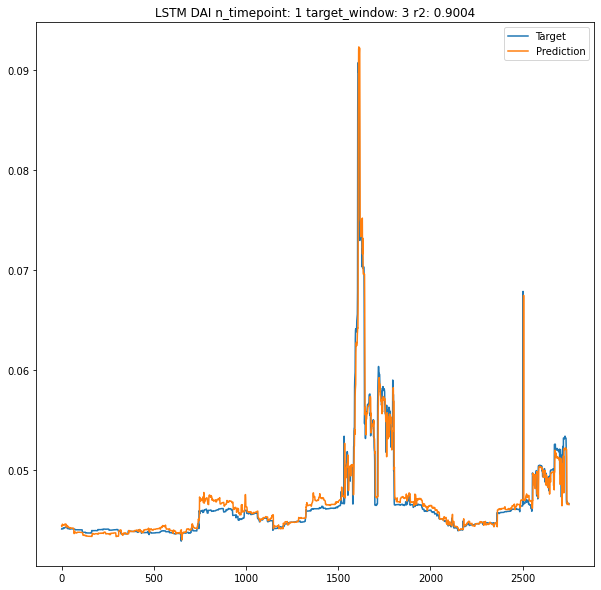

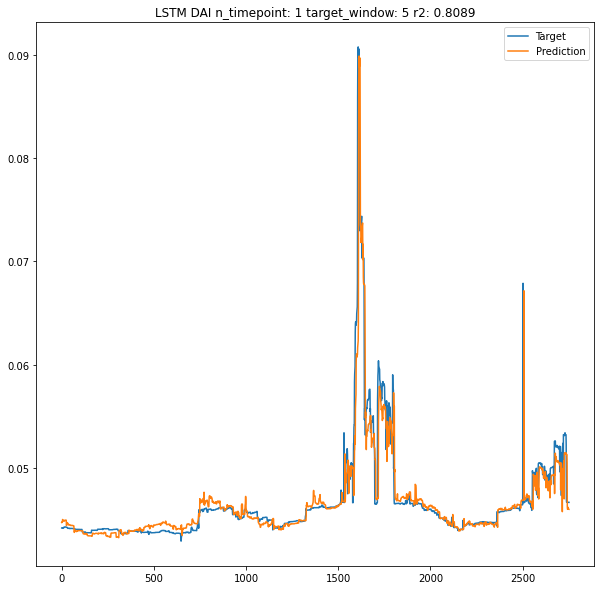

In [ ]:
model_type = 'LSTM'
for tok in ['DAI', 'USDC', 'USDT', 'ETH']:
    for ntp in [1, 3, 10, 20]:
        for tw in [3, 5, 10]:
            learn = get_lstm_learner_train(df1, tok, ntp, tw)
            targs, preds, r2 = get_preds(learn)
            plot_results(model_type, tok, ntp, tw, targs, preds, r2)